In [1]:
# Import du jeu de donnée
import pandas as pd
import numpy as np

# copy on write

df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep = '\t',low_memory=False)
# On enlève les colonnes avec moins de 10% de valeurs présentes
df2_under_10 = df.dropna(thresh=0.2*df.shape[0], axis=1)
# On retire les doublons pour la catégorie code et on garde le premier
df2_under_10 = df2_under_10.drop_duplicates(subset='code', keep='first')
# Les pnns_groups_1 regroupe les différentes catégories de produits, cependant tout n'est pas orthographié de la même manière
df3_pnns = df2_under_10.copy()
# Nettoyage des valeurs de pnns_groups_1, enlever les - et mettre en majuscule, remplacer Unknown par NaN
df3_pnns['pnns_groups_1'] = df3_pnns['pnns_groups_1'].str.replace('-',' ').str.capitalize().replace('Unknown',np.nan)

Nous allons réaliser des box plots en fonction des data que nous avons et par catégorie pour voir si l'on peut prédire le jeu de donnée. A en juger par la matrice de missing no. Une bonne moitié d'entre eux sont présent malgré la présence des _100g. Peut être qu'une méthode de regression logistique pourrait fonctionner. On va réaliser quelques analyses complémentaires pour voir à l'oeil s'il y a quelques variations visuellement intéressantes.

In [2]:
# Se débarasser des valeurs que l'on utilisera pas pour notre analyse (J'ai déjà réalisé le boxplot avec df3_pnns avant, et certaines données ne servait à rien, j'ai donc décidé d'itérer les graphiques qui viendront après avec df4 et df5)
df4_drop = df3_pnns.drop(columns=['url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'nutrition-score-uk_100g'])

In [3]:
import numpy as np

df5_IQR = df4_drop.copy()

for category in df5_IQR['pnns_groups_1'].unique():
    category_data = df5_IQR[df5_IQR['pnns_groups_1'] == category]
    for col in df5_IQR.select_dtypes(include=['float64']).columns:
        Q1 = category_data[col].quantile(0.25)
        Q3 = category_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remplacement des valeurs aberrantes par NaN pour la catégorie et la colonne courantes
        df5_IQR.loc[(df5_IQR['pnns_groups_1'] == category) & 
                    ((df5_IQR[col] < lower_bound) | (df5_IQR[col] > upper_bound)), col] = np.nan

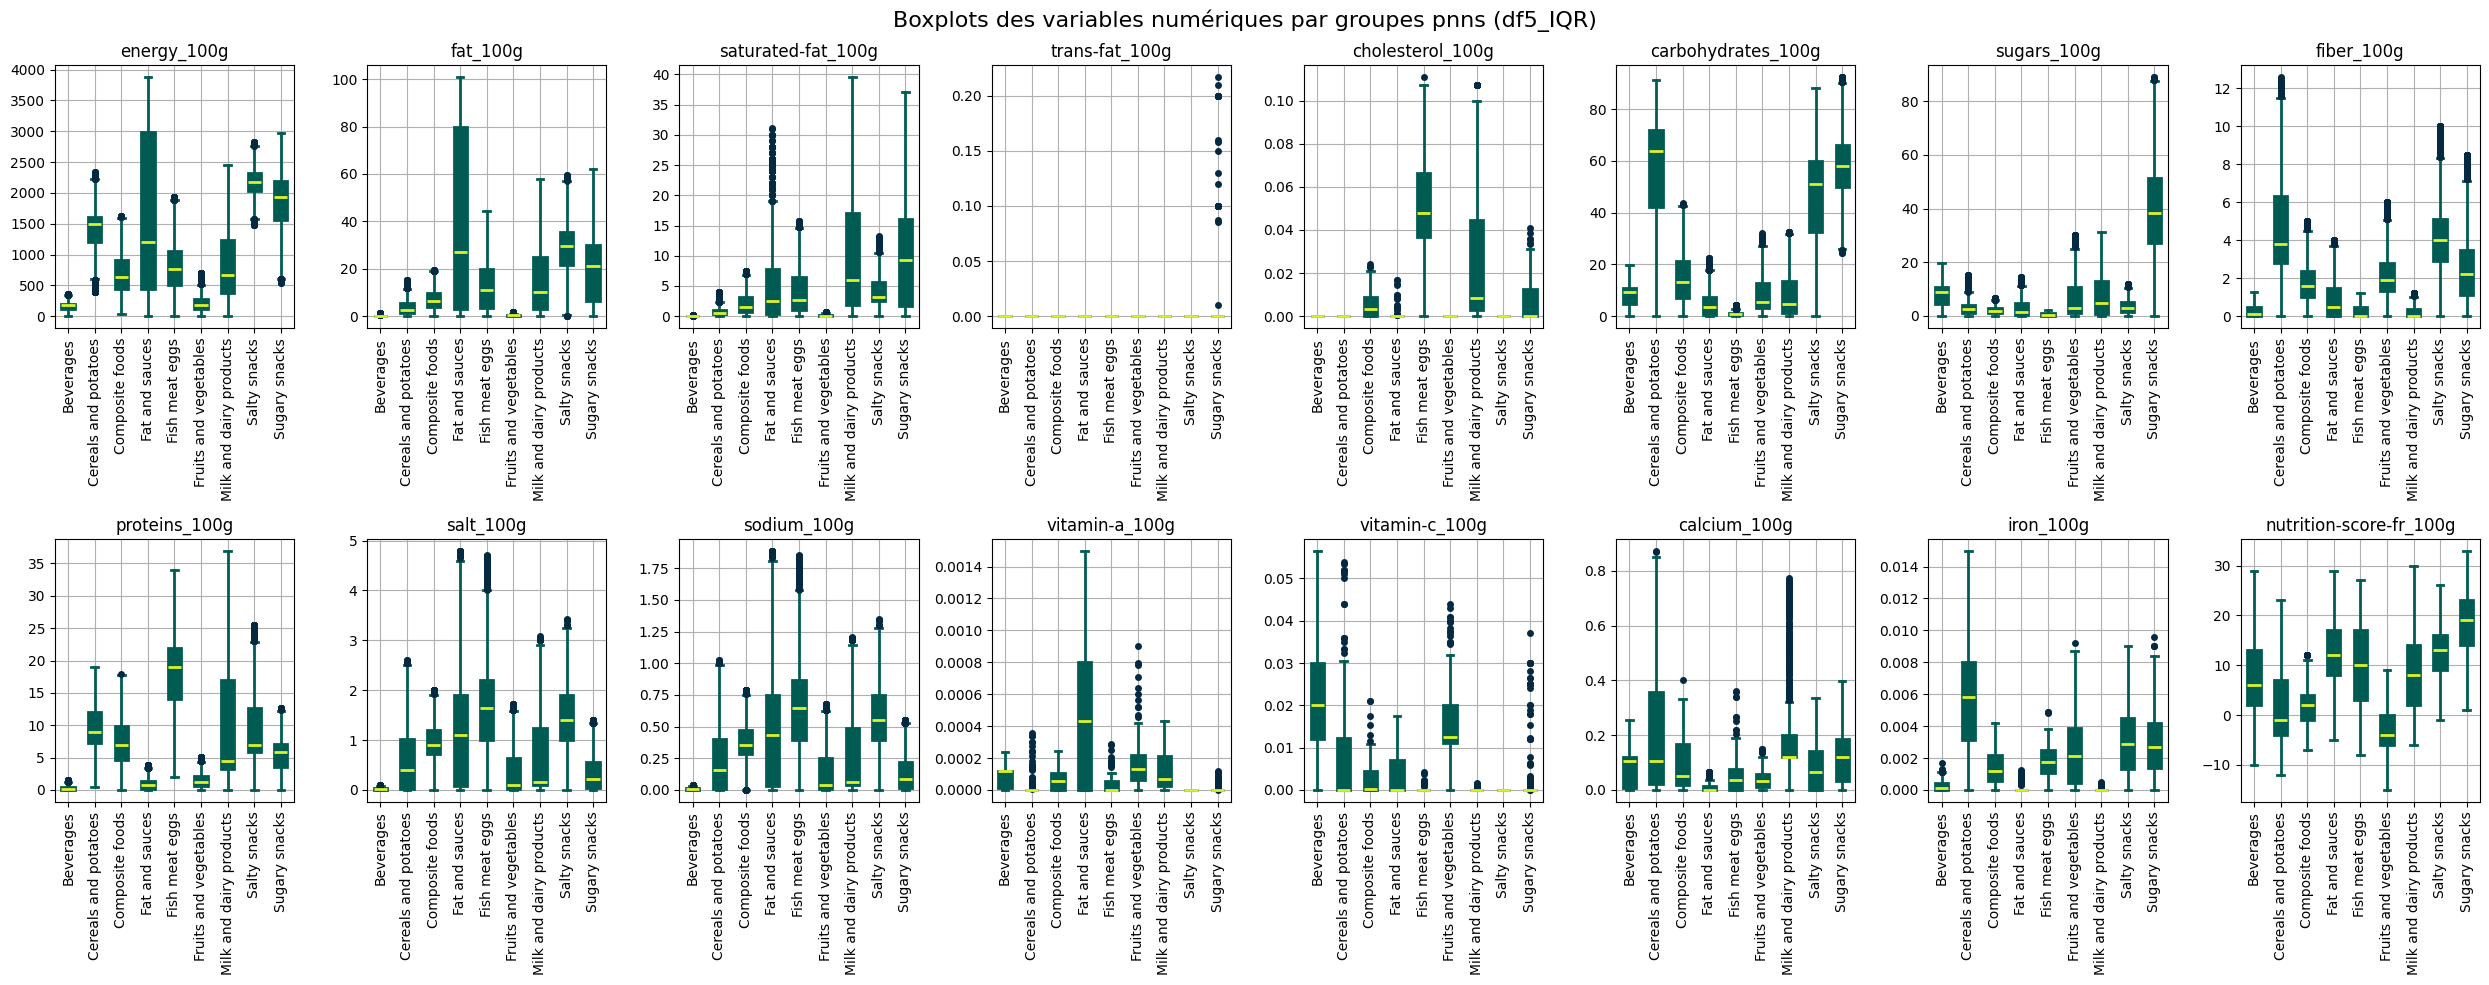

In [35]:
def create_boxplots(df, df_name="DataFrame"):
    # Sélectionner les colonnes numériques
    num_cols = 8
    num_rows = int(np.ceil(len(df.select_dtypes(include=['float64']).columns) / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
    axes = axes.flatten()

    # Créer les boxplots
    for i, col in enumerate(df.select_dtypes(include=['float64']).columns):
        df.boxplot(column=col, by='pnns_groups_1', ax=axes[i], patch_artist=True,
                   boxprops=dict(facecolor='#005C53', color='#005C53', linewidth=2),
                   medianprops=dict(color='#DBF227', linewidth=2),
                   whiskerprops=dict(color='#005C53', linewidth=2),
                   capprops=dict(color='#005C53', linewidth=2),
                   flierprops=dict(marker='o', markersize=5, markerfacecolor='#042940', markeredgewidth=0))
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', labelrotation=90)

    for j in range(i + 1, num_cols * num_rows):
        fig.delaxes(axes[j])

    plt.suptitle(f'Boxplots des variables numériques par groupes pnns ({df_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

create_boxplots(df5_IQR, "df5_IQR")

Les outliers ont été efficacement réduits en utilisant l'IQR par groupe PNNS, c'est plus propre pour réaliser une analyse.
Les groupes de energy_100g, fat_100g, et sugars_100g varient significativement entre les catégories, ce qui permet d'observer des différences claires entre les groupes.

In [16]:
# filtre plus aggressif pour les outliers
df6_IQR = df4_drop.copy()

# quartile
Q1 = df6_IQR.select_dtypes(include=['float64']).quantile(0.25)
Q3 = df6_IQR.select_dtypes(include=['float64']).quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

for col in df6_IQR.select_dtypes(include=['float64']).columns:
    df6_IQR.loc[(df6_IQR[col] < lower_bound[col]) | (df6_IQR[col] > upper_bound[col]), col] = np.nan

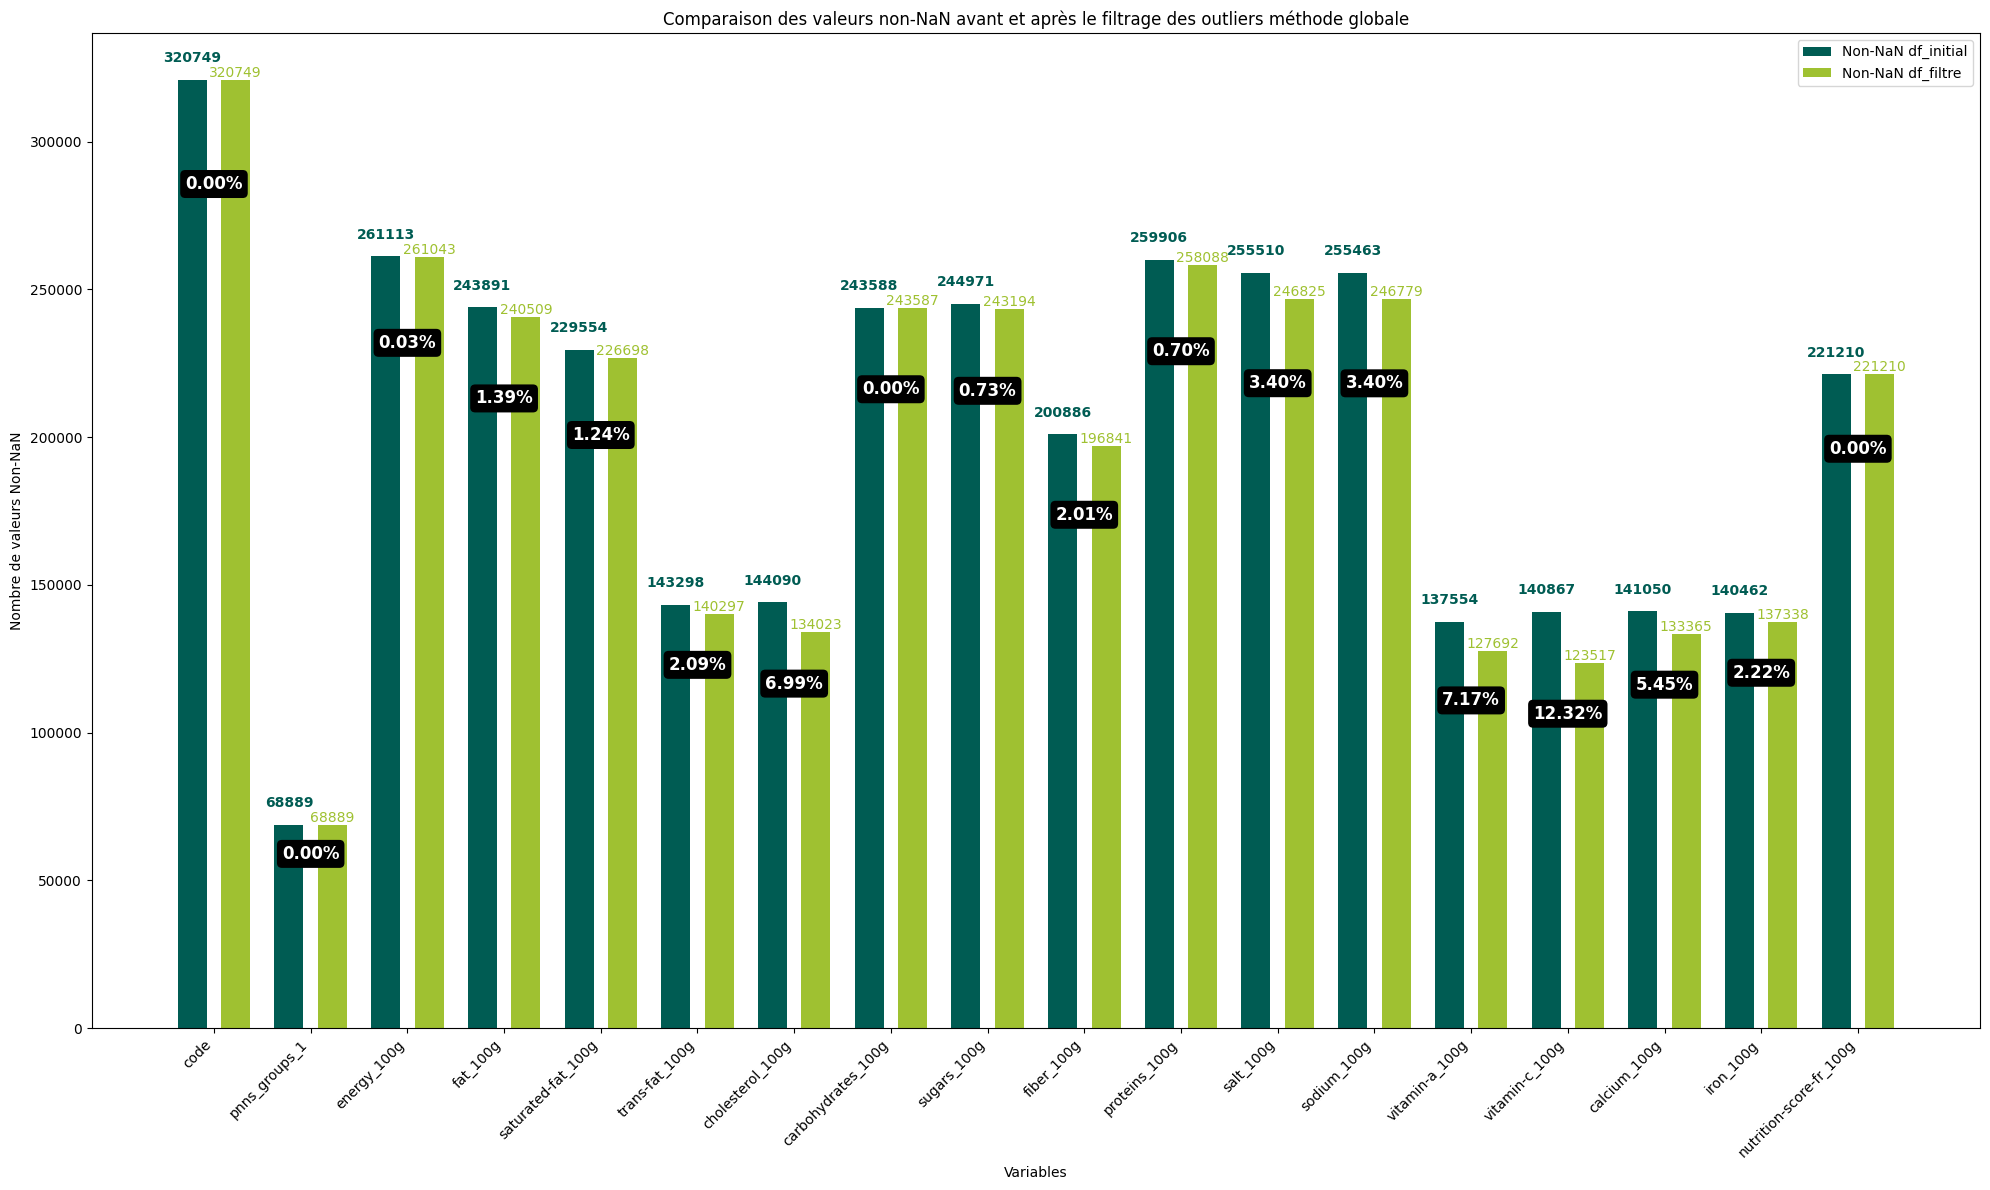

Quantité de NaN supplémentaire après traitement : 82407


In [41]:
def comparer_valeurs_non_nan(df_initial, df_filtre, titre=""):
    # Calcul des statistiques sur les NaN et non-NaN
    df_initial_non_nan = df_initial.notna().sum()
    df_filtre_non_nan = df_filtre.notna().sum()

    # Préparer les données pour le graphique
    variables = df_initial_non_nan.index
    non_nan_df_initial = df_initial_non_nan.values
    non_nan_df_filtre = df_filtre_non_nan.values

    # Calcul des pourcentages de réduction
    pourcentage_reduction = ((non_nan_df_initial - non_nan_df_filtre) / non_nan_df_initial) * 100

    # Indices pour le placement des barres
    x = np.arange(len(variables)) * 2  # Augmenter l'espacement entre les groupes de barres

    # Largeur des barres
    largeur = 0.6
    espacement_barres = 0.3  # Espacement entre les barres de chaque groupe

    # Couleurs des barres
    couleur_df_initial = '#005C53'  # Bleu foncé
    couleur_df_filtre = '#9FC131'  # Vert foncé

    # Créer le graphique pour la comparaison des non-NaN avant et après
    fig, ax = plt.subplots(figsize=(20, 12))

    # Barres pour df_initial et df_filtre côte à côte avec espacement
    bar1 = ax.bar(x - (largeur + espacement_barres)/2, non_nan_df_initial, largeur, label='Non-NaN df_initial', color=couleur_df_initial)
    bar2 = ax.bar(x + (largeur + espacement_barres)/2, non_nan_df_filtre, largeur, label='Non-NaN df_filtre', color=couleur_df_filtre)

    # Ajouter des étiquettes de données et des commentaires sur les pourcentages de réduction
    for i in range(len(variables)):
        # Réhausser uniquement les étiquettes de données des barres df_initial
        ax.text(x[i] - (largeur + espacement_barres)/2, non_nan_df_initial[i] + 5000, str(non_nan_df_initial[i]), ha='center', va='bottom', fontsize=10, color=couleur_df_initial, fontweight='bold')
        # Laisser les étiquettes de données des barres df_filtre à leur position d'origine
        ax.text(x[i] + (largeur + espacement_barres)/2, non_nan_df_filtre[i], str(non_nan_df_filtre[i]), ha='center', va='bottom', fontsize=10, color=couleur_df_filtre)
        # Ajouter les pourcentages de réduction avec une boîte noire sans bordure
        ax.text(x[i], min(non_nan_df_initial[i], non_nan_df_filtre[i]) - (max(non_nan_df_initial[i], non_nan_df_filtre[i]) * 0.10), 
                f'{pourcentage_reduction[i]:.2f}%', ha='center', va='top', color='white', fontsize=12, fontweight='bold',
                bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_xlabel('Variables')
    ax.set_ylabel('Nombre de valeurs Non-NaN')
    ax.set_title(f'{titre}')
    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()
    
comparer_valeurs_non_nan(df4_drop, df6_IQR, "Comparaison des valeurs non-NaN avant et après le filtrage des outliers méthode globale")

# Quantité de NaN ajoutés
print(f"Quantité de NaN supplémentaire après traitement : {df6_IQR.isna().sum().sum() - df4_drop.isna().sum().sum()}")

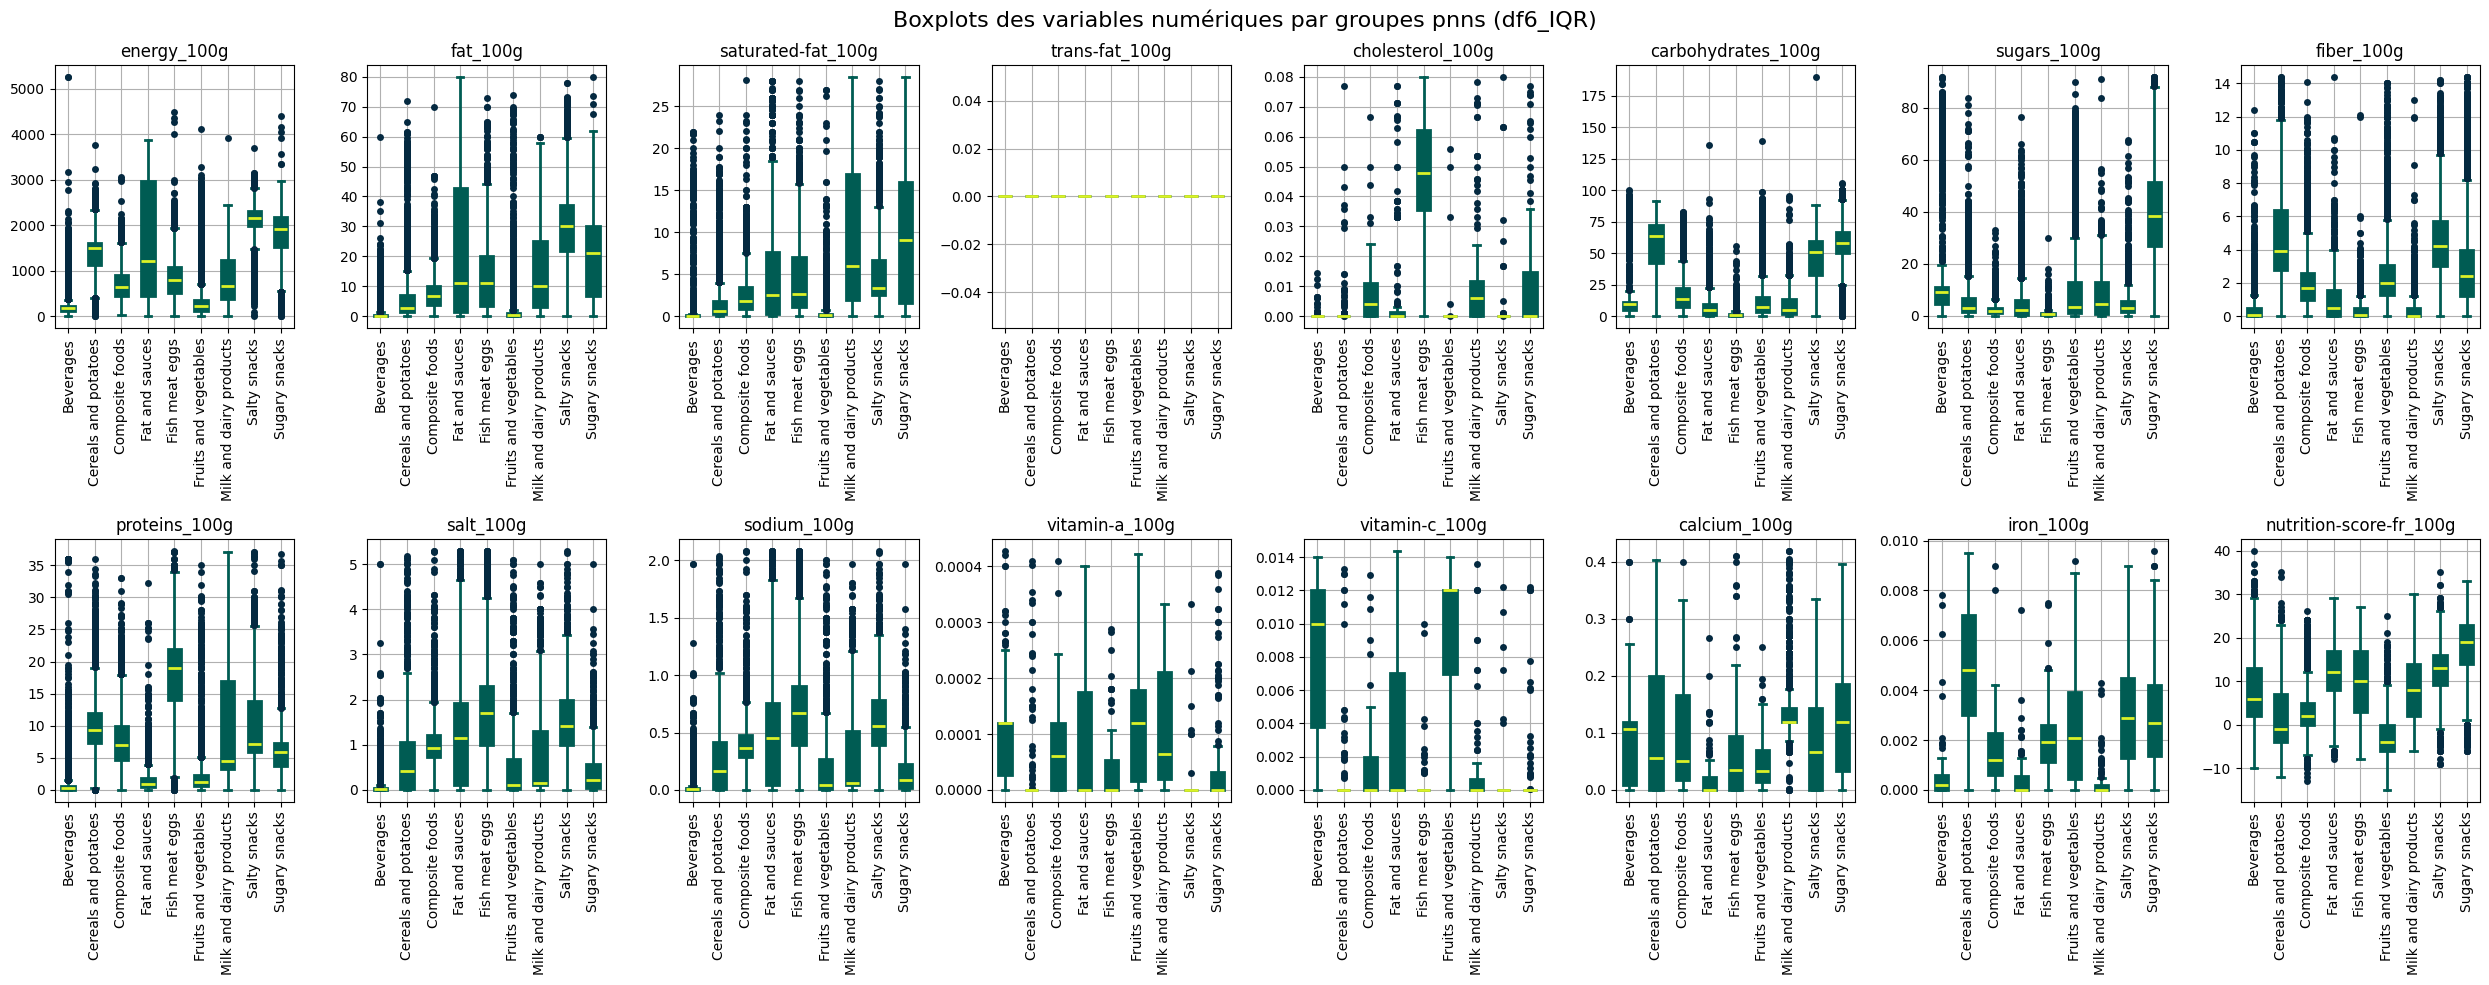

In [37]:
# box plots des variables numériques après filtrage des outliers

create_boxplots(df6_IQR, "df6_IQR")

In [6]:
from sklearn.preprocessing import StandardScaler
df10_pca = df6_IQR.copy()
df10_pca = df10_pca[df10_pca['code'] != '3257983115628'] # On retire la ligne avec le code 3257983115628 car cet individu a été identifié comme outlier dans une analyse précédente
df10_pca = df10_pca.select_dtypes(include=['float64'])

# remplacement des NaN par la médiane
df10_pca = df10_pca.fillna(df10_pca.median())

# Standardisation des données
scaler = StandardScaler()
X10 = df10_pca.select_dtypes(include=['float64'])
X10_scaled = scaler.fit_transform(X10)


In [7]:
# Réduction de dimension avec PCA
from sklearn.decomposition import PCA

pca = PCA()
X10_pca = pca.fit_transform(X10_scaled)

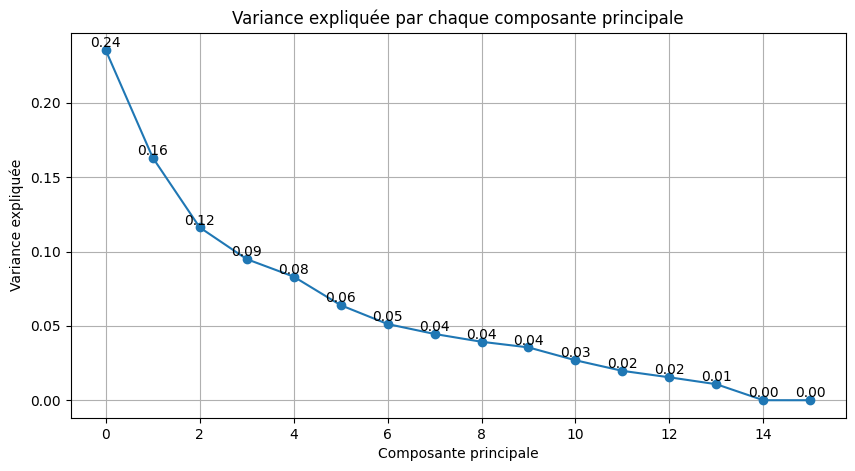

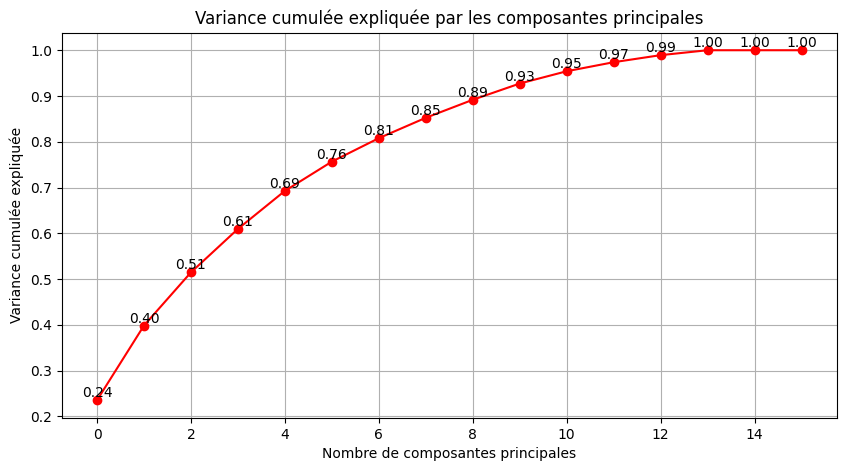

In [8]:
# Affichage de la variance expliquée par chaque composante principale
plt.figure(figsize=(10, 5))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Variance expliquée par chaque composante principale')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
for i, v in enumerate(pca.explained_variance_ratio_):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.grid(True)
plt.show()


# Affichage de la variance cumulée expliquée par les composantes principales
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='red')
plt.title('Variance cumulée expliquée par les composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance cumulée expliquée')
for i, v in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.grid(True)
plt.show()


A partir de 6 composantes on peut expliquer 80 % de la variance c'est un regroupement utile.

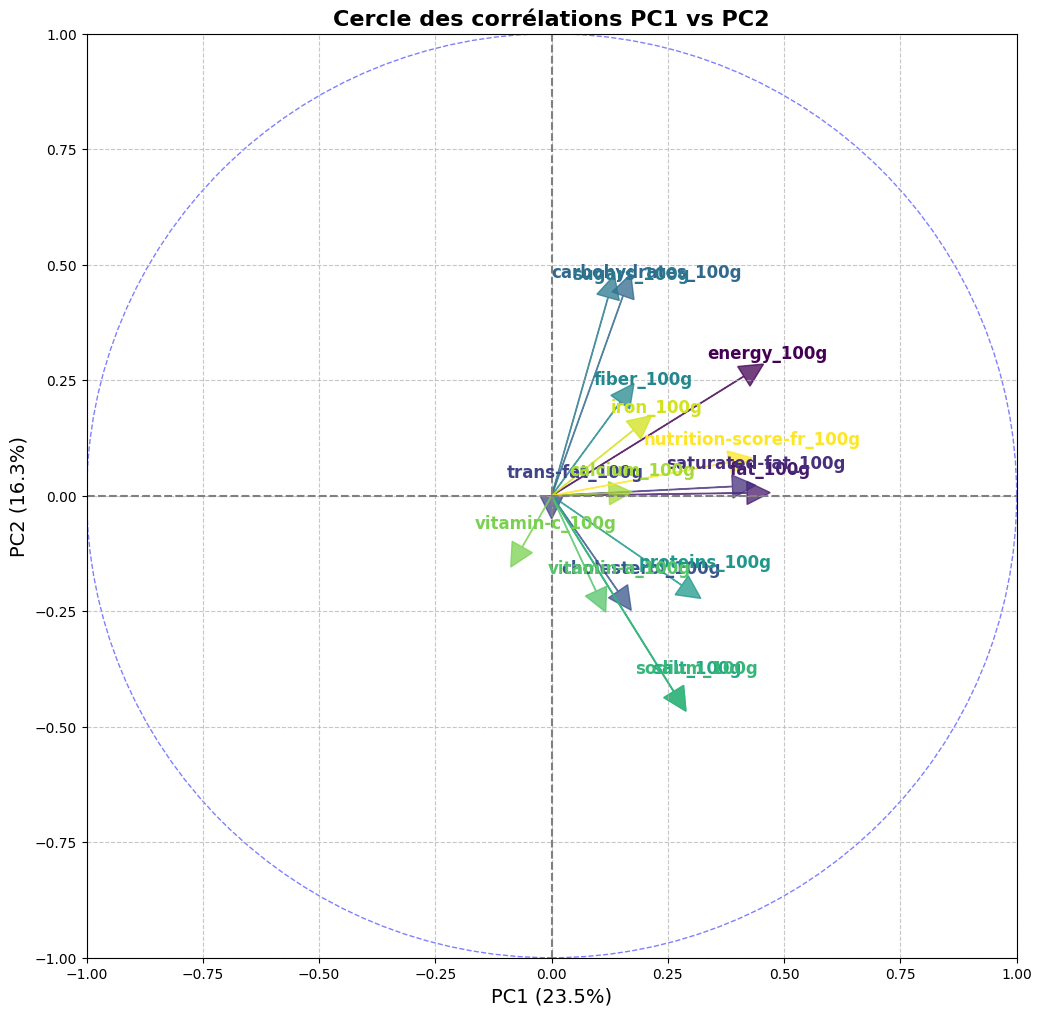

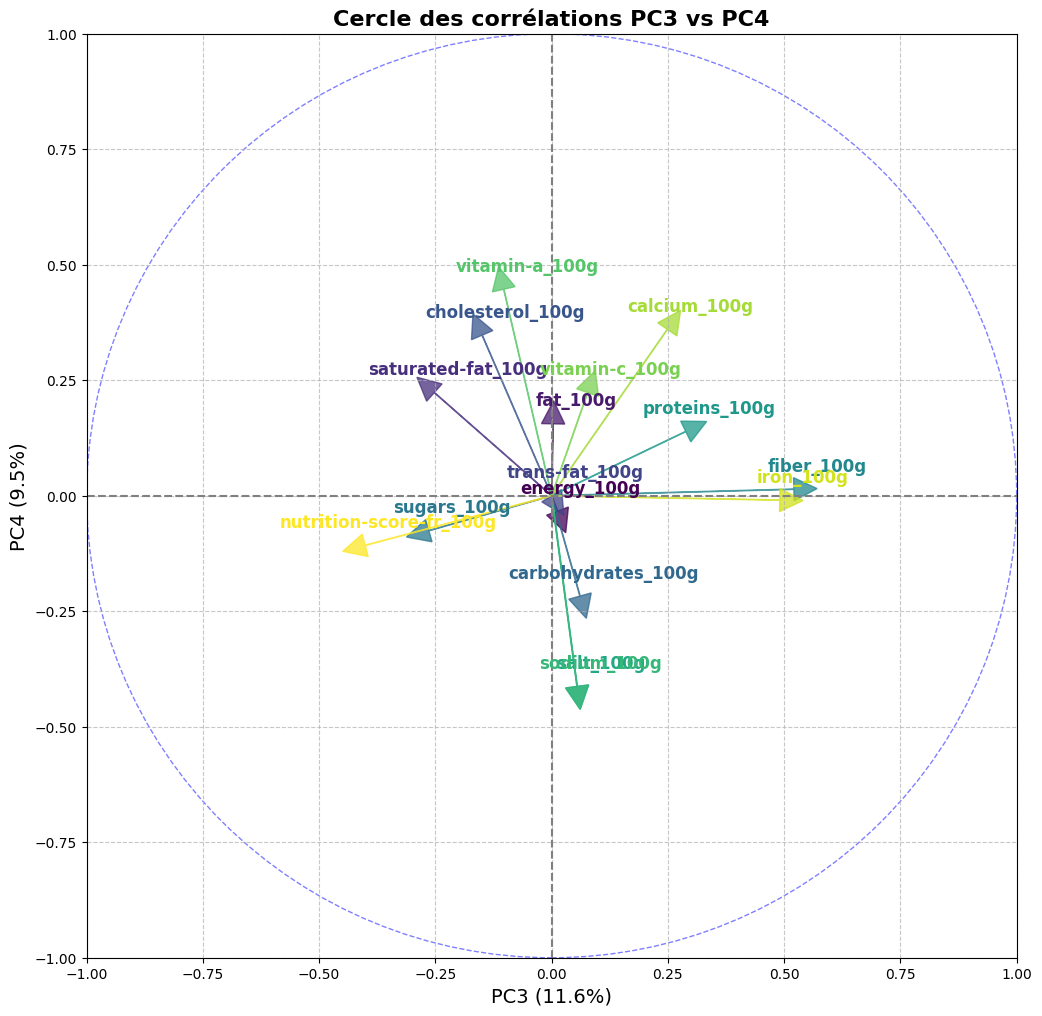

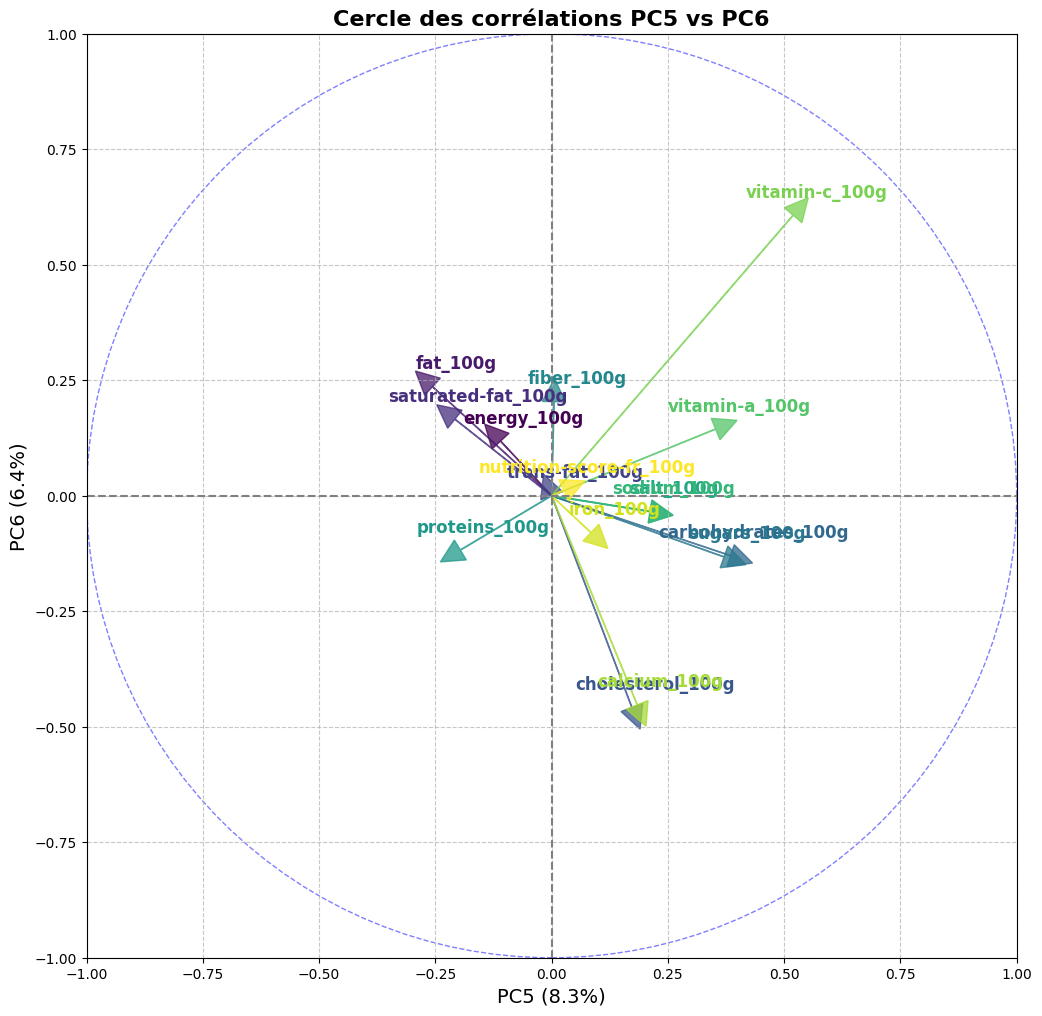

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def correlation_graph(pca, features, pc_x=0, pc_y=1, title='Cercle des corrélations'):
    plt.figure(figsize=(12, 12))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
    for i, (component_x, component_y) in enumerate(zip(pca.components_[pc_x], pca.components_[pc_y])):
        plt.arrow(0, 0, component_x, component_y, 
                  head_width=0.05, head_length=0.05, color=colors[i], alpha=0.75)
        plt.text(component_x + 0.05, component_y + 0.05, 
                 features[i], color=colors[i], ha='center', va='center', fontsize=12, weight='bold')
    
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f'PC{pc_x+1} ({pca.explained_variance_ratio_[pc_x]*100:.1f}%)', fontsize=14)
    plt.ylabel(f'PC{pc_y+1} ({pca.explained_variance_ratio_[pc_y]*100:.1f}%)', fontsize=14)
    plt.grid(ls='--', alpha=0.7)
    plt.axhline(0, color='grey', ls='--')
    plt.axvline(0, color='grey', ls='--')
    circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b', ls='--', alpha=0.5)
    plt.gca().add_artist(circle)
    plt.title(title, fontsize=16, weight='bold')
    plt.show()

# Appel de la fonction avec les colonnes numériques de votre DataFrame
correlation_graph(pca, X10.columns, 0, 1, 'Cercle des corrélations PC1 vs PC2')
correlation_graph(pca, X10.columns, 2, 3, 'Cercle des corrélations PC3 vs PC4')
correlation_graph(pca, X10.columns, 4, 5, 'Cercle des corrélations PC5 vs PC6')

# On garde les 6 premières composantes principales
df10_pca = df10_pca.iloc[:, :6]

# On ajoute les colonnes de catégorie et de code
df10_pca['pnns_groups_1'] = df6_IQR['pnns_groups_1']
df10_pca['code'] = df6_IQR['code']


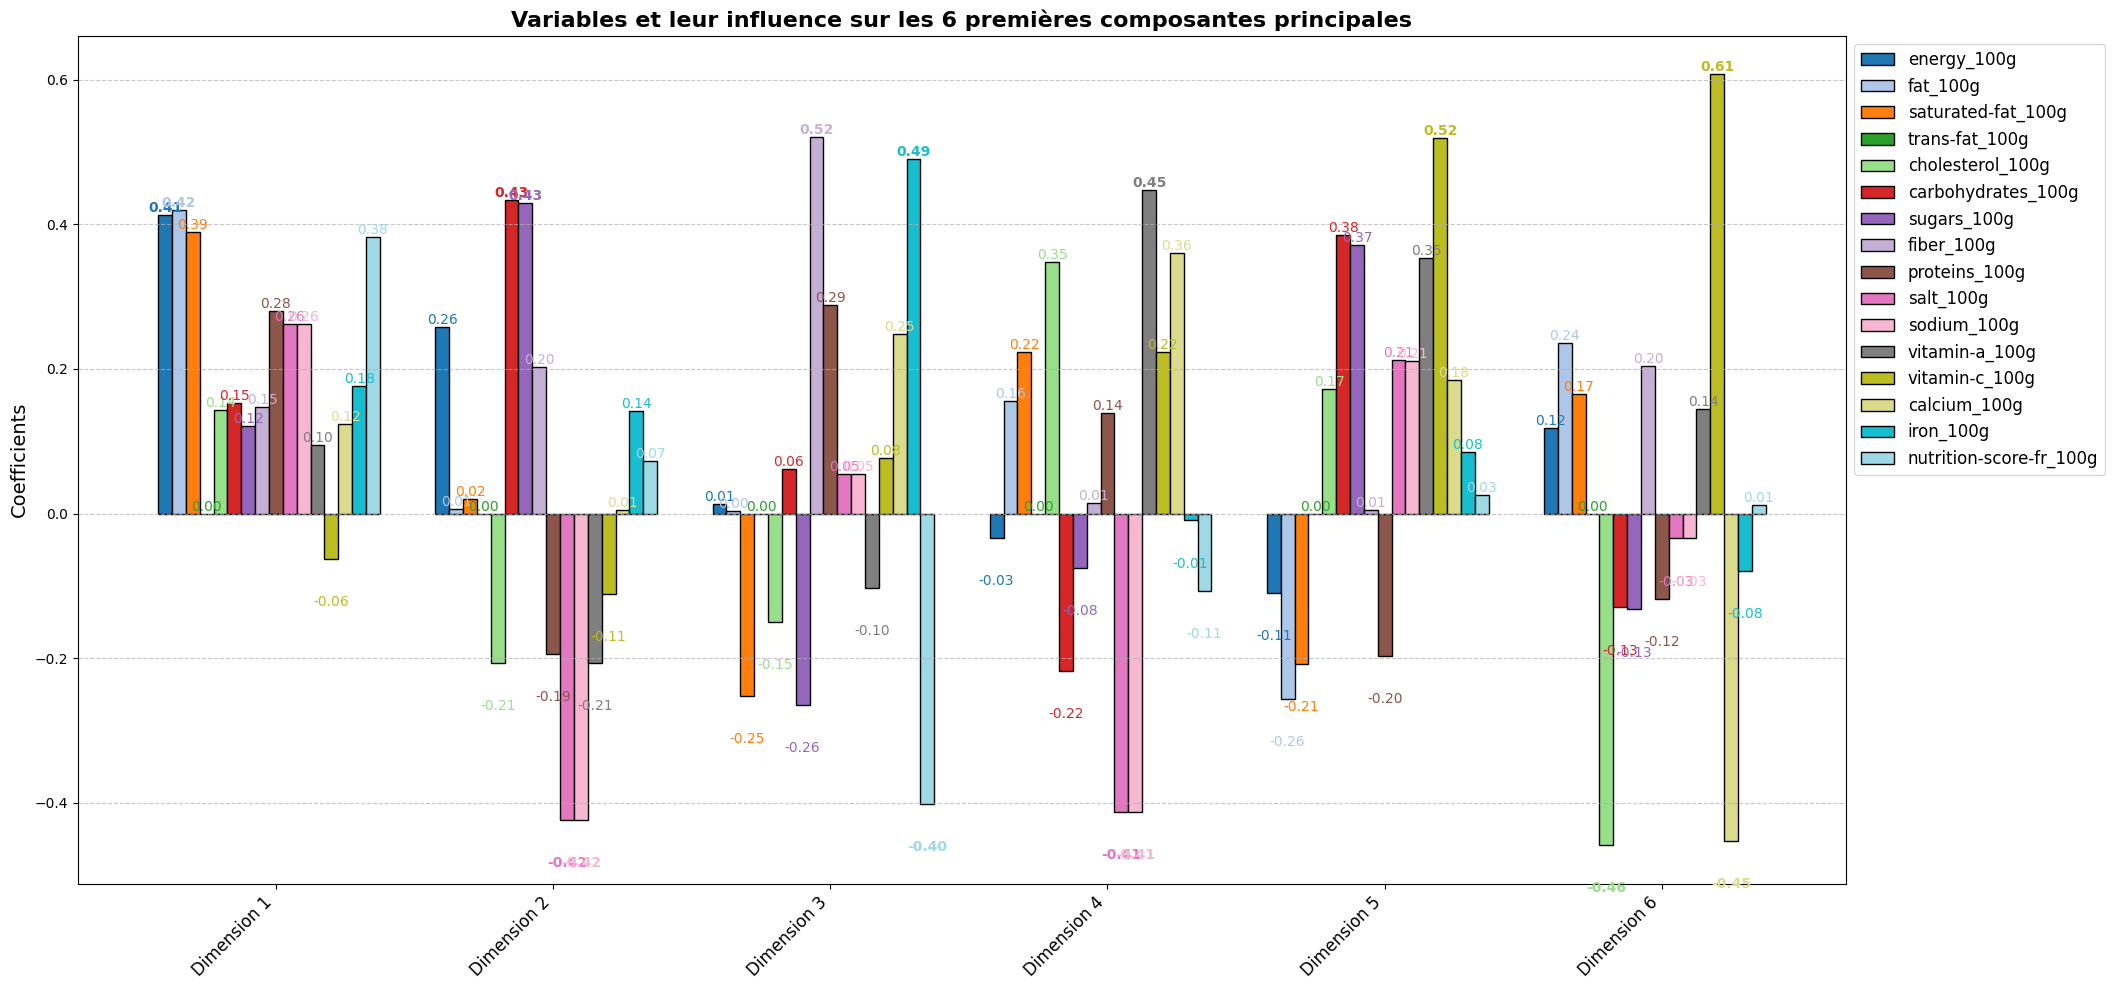

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def pca_results(pca, features):
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns=features)
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
    variance_ratios.index = dimensions
    return pd.concat([variance_ratios, components], axis=1)


def pca_results_graph(pca, features, num_components=6):
    dimensions = ['Dimension {}'.format(i) for i in range(1, num_components+1)]
    components = pd.DataFrame(np.round(pca.components_[:num_components], 4), columns=features)
    components.index = dimensions
    
    fig, ax = plt.subplots(figsize=(25, 10))
    cmap = plt.get_cmap('tab20', len(features))
    colors = [cmap(i) for i in range(len(features))]
    bar_width = 0.8 / len(features)  # Ajuste la largeur des barres
    
    for i, feature in enumerate(features):
        bars = ax.bar(np.arange(num_components) + i * bar_width, components[feature], bar_width, label=feature, color=colors[i], edgecolor='black')
        
        # Ajout des étiquettes de données ajustées et colorées
        for bar in bars:
            height = bar.get_height()
            if height > 0.40 or height < -0.40:
                label = f'{height:.2f}'
                weight = 'bold'
            else:
                label = f'{height:.2f}'
                weight = 'normal'
            
            # Afficher les étiquettes au-dessus des barres pour les valeurs positives et en dessous pour les valeurs négatives
            ax.text(bar.get_x() + bar.get_width() / 2, height if height >= 0 else height - 0.05, label,
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, color=colors[i], weight=weight)
    
    ax.set_ylabel('Coefficients', fontsize=14)
    ax.set_xticks(np.arange(num_components) + bar_width * (len(features) / 2))
    ax.set_xticklabels(dimensions, rotation=45, ha='right', fontsize=12)
    ax.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1), ncol=1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.title('Variables et leur influence sur les 6 premières composantes principales', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajuste la mise en page pour éviter le chevauchement des légendes
    plt.show()

# Utilisation des fonctions avec les 6 premières composantes
pca_results_graph(pca, X10.columns, 6)